# Import

기업 성공확률 예측 모델

In [104]:
%pip install pytorch-tabnet

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import torch
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor

Note: you may need to restart the kernel to use updated packages.


# Data Load

In [105]:
#원본 유지
origin_train = pd.read_csv('train.csv')
origin_test = pd.read_csv('test.csv')

In [106]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Data Preprocessing

In [107]:
train.head()

,ID,설립연도,국가,분야,투자단계,직원 수,인수여부,상장여부,고객수(백만명),총 투자금(억원),연매출(억원),SNS 팔로워 수(백만명),기업가치(백억원),성공확률
0,TRAIN_0000,2009,CT005,이커머스,Series A,4126.0,No,No,56.0,3365.0,4764.0,4.71,NaN,0.3
1,TRAIN_0001,2023,CT006,핀테크,Seed,4167.0,Yes,No,80.0,4069.0,279.0,1.00,2500-3500,0.8
2,TRAIN_0002,2018,CT007,기술,Series A,3132.0,Yes,Yes,54.0,6453.0,12141.0,4.00,3500-4500,0.5
3,TRAIN_0003,2016,CT006,NaN,Seed,3245.0,Yes,Yes,NaN,665.0,10547.0,2.97,NaN,0.7
4,TRAIN_0004,2020,CT002,에듀테크,Seed,1969.0,No,Yes,94.0,829.0,9810.0,1.00,1500-2500,0.1


In [108]:
train.columns

Index(['ID', '설립연도', '국가', '분야', '투자단계', '직원 수', '인수여부', '상장여부', '고객수(백만명)',
       '총 투자금(억원)', '연매출(억원)', 'SNS 팔로워 수(백만명)', '기업가치(백억원)', '성공확률'],
      dtype='object')

In [109]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4376 entries, 0 to 4375
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              4376 non-null   object 
 1   설립연도            4376 non-null   int64  
 2   국가              4376 non-null   object 
 3   분야              3519 non-null   object 
 4   투자단계            4376 non-null   object 
 5   직원 수            4202 non-null   float64
 6   인수여부            4376 non-null   object 
 7   상장여부            4376 non-null   object 
 8   고객수(백만명)        3056 non-null   float64
 9   총 투자금(억원)       4376 non-null   float64
 10  연매출(억원)         4376 non-null   float64
 11  SNS 팔로워 수(백만명)  4376 non-null   float64
 12  기업가치(백억원)       3156 non-null   object 
 13  성공확률            4376 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 478.8+ KB


In [110]:
train.isna().sum()

ID                   0
설립연도                 0
국가                   0
분야                 857
투자단계                 0
직원 수               174
인수여부                 0
상장여부                 0
고객수(백만명)          1320
총 투자금(억원)            0
연매출(억원)              0
SNS 팔로워 수(백만명)       0
기업가치(백억원)         1220
성공확률                 0
dtype: int64

In [111]:
test.isna().sum()

ID                  0
설립연도                0
국가                  0
분야                354
투자단계                0
직원 수               76
인수여부                0
상장여부                0
고객수(백만명)          547
총 투자금(억원)           0
연매출(억원)             0
SNS 팔로워 수(백만명)      0
기업가치(백억원)         487
dtype: int64

- 결측치 컬럼: 분야(object), 직원수, 고객수, 기업가치(object)

In [112]:
#특성과 타겟 변수 분리
train = train.drop(columns=['ID'], axis = 1)
test = test.drop(columns=['ID'], axis = 1)

In [113]:
# 각 컬럼별 결측치 비율 계산
missing_ratio = train.isnull().mean().sort_values(ascending=False)

# 결측치 비율이 0보다 큰 컬럼만 추출
missing_ratio = missing_ratio[missing_ratio > 0]

# 보기 좋게 %로 표시
missing_ratio_percent = (missing_ratio * 100).round(2)
print(missing_ratio_percent)

고객수(백만명)     30.16
기업가치(백억원)    27.88
분야           19.58
직원 수          3.98
dtype: float64


C:\Users\starf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


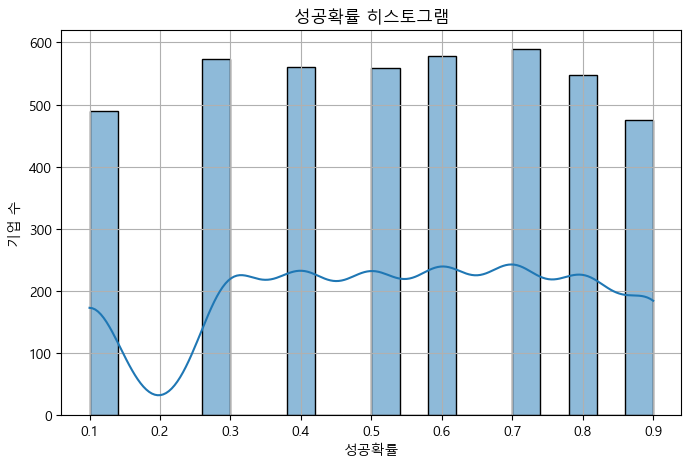

In [114]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 한글 폰트 설정 (Windows의 기본 폰트인 'Malgun Gothic' 사용)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 예시: 한글 포함된 히스토그램
plt.figure(figsize=(8, 5))
sns.histplot(train['성공확률'], bins=20, kde=True)
plt.title('성공확률 히스토그램')
plt.xlabel('성공확률')
plt.ylabel('기업 수')
plt.grid(True)
plt.show()

In [115]:
# 설립연도 타입 변환 (int -> object)
train['설립연도'] =train['설립연도'].astype('object')
test['설립연도'] =test['설립연도'].astype('object')

category_features = ['설립연도','국가','분야','투자단계','기업가치(백억원)'] #범주형
numeric_features = ['직원 수','고객수(백만명)','총 투자금(억원)','연매출(억원)','SNS 팔로워 수(백만명)'] #수치형
bool_features = ['인수여부','상장여부'] 

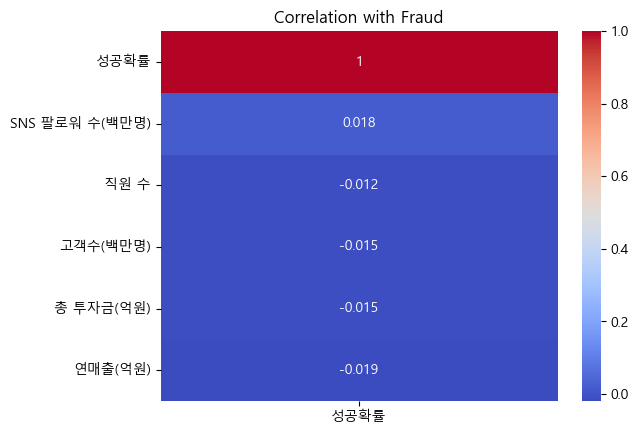

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

# 수치형 칼럼만 선택
numeric_cols = train.select_dtypes(include=['number'])

# 히트맵
sns.heatmap(numeric_cols.corr()[['성공확률']].sort_values(by='성공확률', ascending=False),
            annot=True, cmap='coolwarm')
plt.title("Correlation with Fraud")
plt.show()

## ANOVA
- 여러 그룹 간의 통계적으로 유의미한 차이를 검정하는 통계적 절차

In [117]:
train.columns

Index(['설립연도', '국가', '분야', '투자단계', '직원 수', '인수여부', '상장여부', '고객수(백만명)',
       '총 투자금(억원)', '연매출(억원)', 'SNS 팔로워 수(백만명)', '기업가치(백억원)', '성공확률'],
      dtype='object')

### 가설 설정 (이진변수를 기준으로 연속형 값의 평균 차이를 비교할 것임)
- 1. 인수여부, 상장여부가 참이면 성공확률은 증가할 것이다.
    - 귀무가설: 인수 여부/상장여부에 따라 성공확률의 평균은 차이가 없다.
    - 대립가설: 인수/상장된 기업이 인수/상장되지 않은 기업보다 평균 성공확률이 높다.

In [118]:
# 불리언 값을 0과 1로 변환 ('Yes' → 1, 'No' → 0 으로 변환)
bool_map = {'Yes': 1, 'No': 0}

for feature in bool_features:
    train[feature] = train[feature].map(bool_map)
    test[feature] = test[feature].map(bool_map)

### 독립표본 t-검정

In [119]:
from scipy.stats import ttest_ind

# 상장 여부에 따라 그룹 나누기
group_listed = train[train['상장여부'] == 1]['성공확률']
group_not_listed = train[train['상장여부'] == 0]['성공확률']

# t-test 수행
t_stat, p_value = ttest_ind(group_listed, group_not_listed, equal_var=False)

print(f"t-statistic: {t_stat}, p-value: {p_value}")

t-statistic: 2.079154933489617, p-value: 0.037661451984323246


In [120]:
# 인수 여부에 따라 그룹 나누기
group_listed = train[train['인수여부'] == 1]['성공확률']
group_not_listed = train[train['인수여부'] == 0]['성공확률']

# t-test 수행
t_stat, p_value = ttest_ind(group_listed, group_not_listed, equal_var=False)

print(f"t-statistic: {t_stat}, p-value: {p_value}")

t-statistic: -0.797801799825947, p-value: 0.4250290406586925


- 상장 여부에 따른 성공확률의 평균 차이가 통계적으로 유의함 (0.05 이하)

### 이원분산분석 (인수여부+상장여부)

In [121]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 두 범주형 변수의 효과를 동시에 분석
model = ols('성공확률 ~ C(인수여부) + C(상장여부) + C(인수여부):C(상장여부)', data=train).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                     sum_sq      df         F    PR(>F)
C(인수여부)            0.033116     1.0  0.567174  0.451425
C(상장여부)            0.248108     1.0  4.249308  0.039325
C(인수여부):C(상장여부)    0.021626     1.0  0.370382  0.542828
Residual         255.271702  4372.0       NaN       NaN


- 상장여부만 성공확률에 유의한 긍정적 영향을 주는 반면,
- 인수여부 자체나 인수+상장의 상호작용은 유의하지 않은 것으로 판명

In [122]:
# 상장 여부에 따른 성공확률 평균 비교
mean_success_by_listing = train.groupby('상장여부')['성공확률'].mean()
print(mean_success_by_listing)

상장여부
0    0.530004
1    0.545196
Name: 성공확률, dtype: float64


- 그러나 실제 차이 크기는 작음. 데이터 수가 적어서 그룹 간 평균 차이가 작아도 유의할 수 있음

### 범주형 변수 시각화

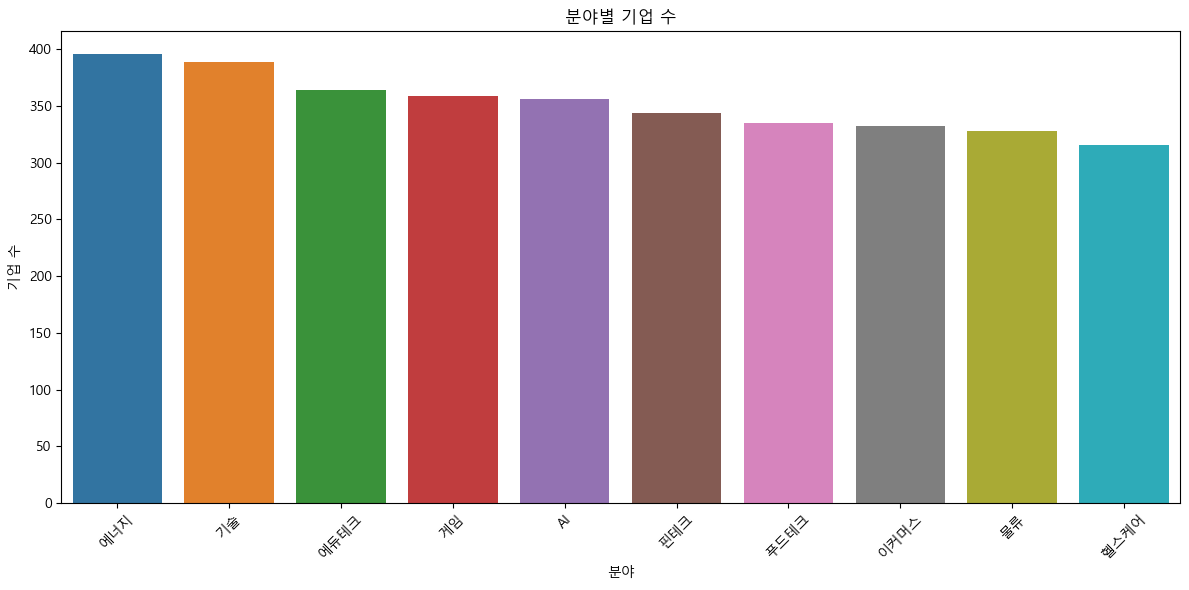

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(data=train, x='분야', order=train['분야'].value_counts().index)

plt.title('분야별 기업 수')
plt.xlabel('분야')
plt.ylabel('기업 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

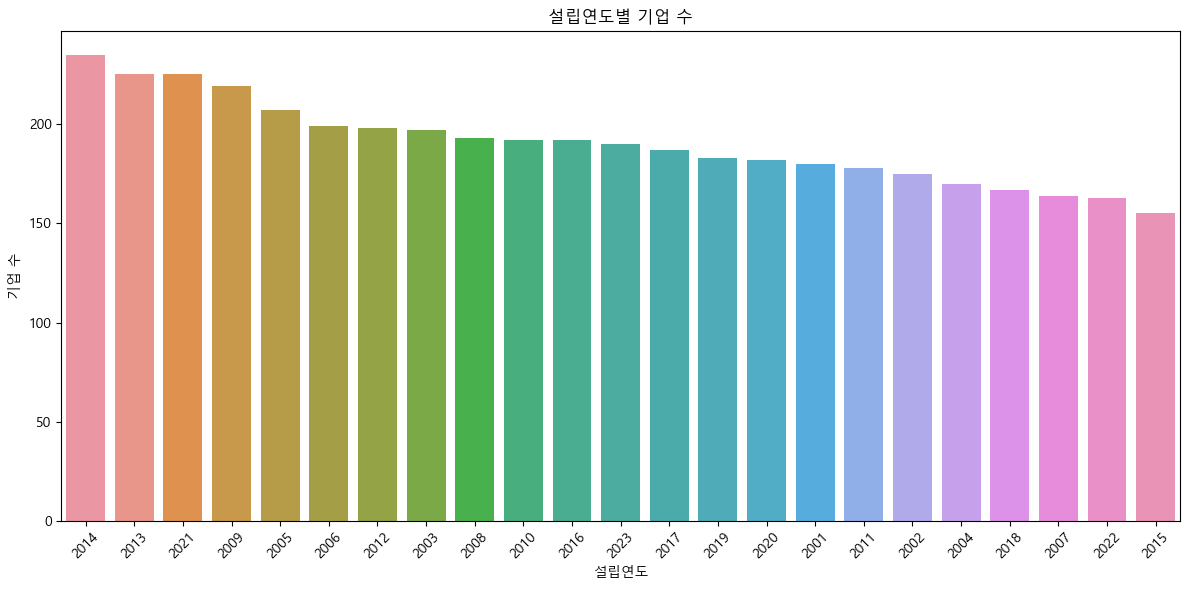

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(data=train, x='설립연도', order=train['설립연도'].value_counts().index)

plt.title('설립연도별 기업 수')
plt.xlabel('설립연도')
plt.ylabel('기업 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

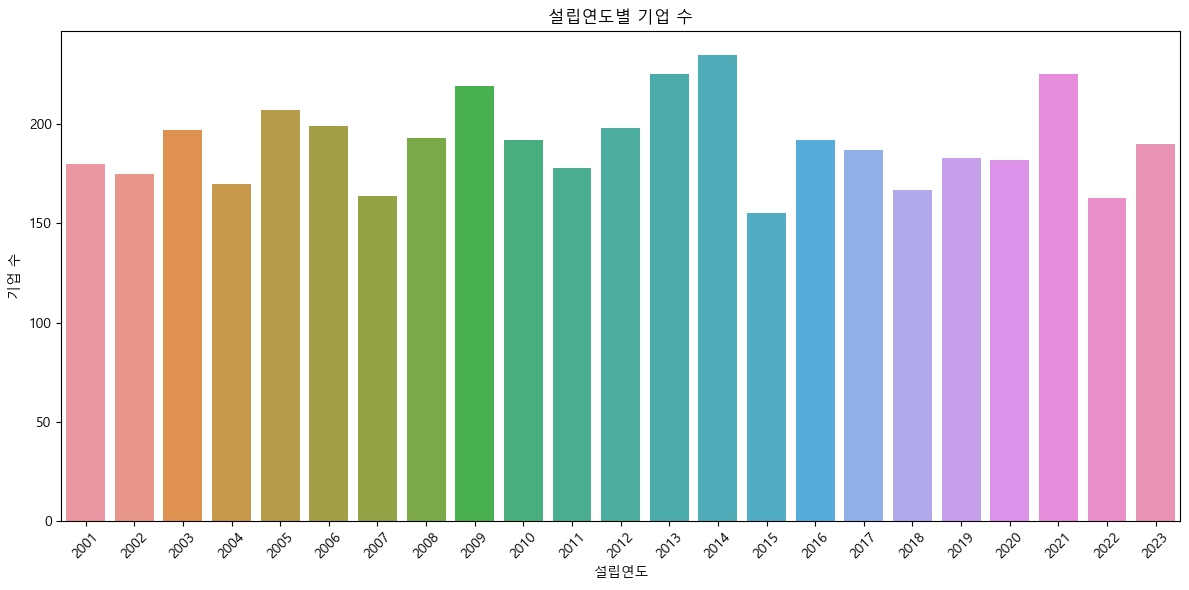

In [125]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train, x='설립연도')

plt.title('설립연도별 기업 수')
plt.xlabel('설립연도')
plt.ylabel('기업 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

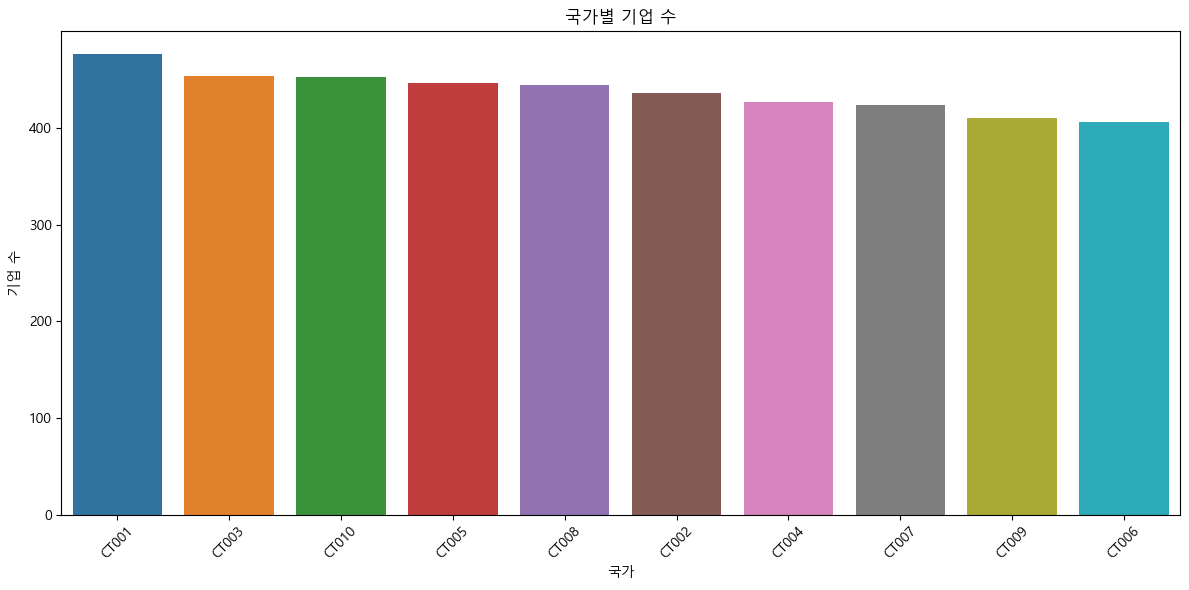

In [126]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train, x='국가', order=train['국가'].value_counts().index)

plt.title('국가별 기업 수')
plt.xlabel('국가')
plt.ylabel('기업 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

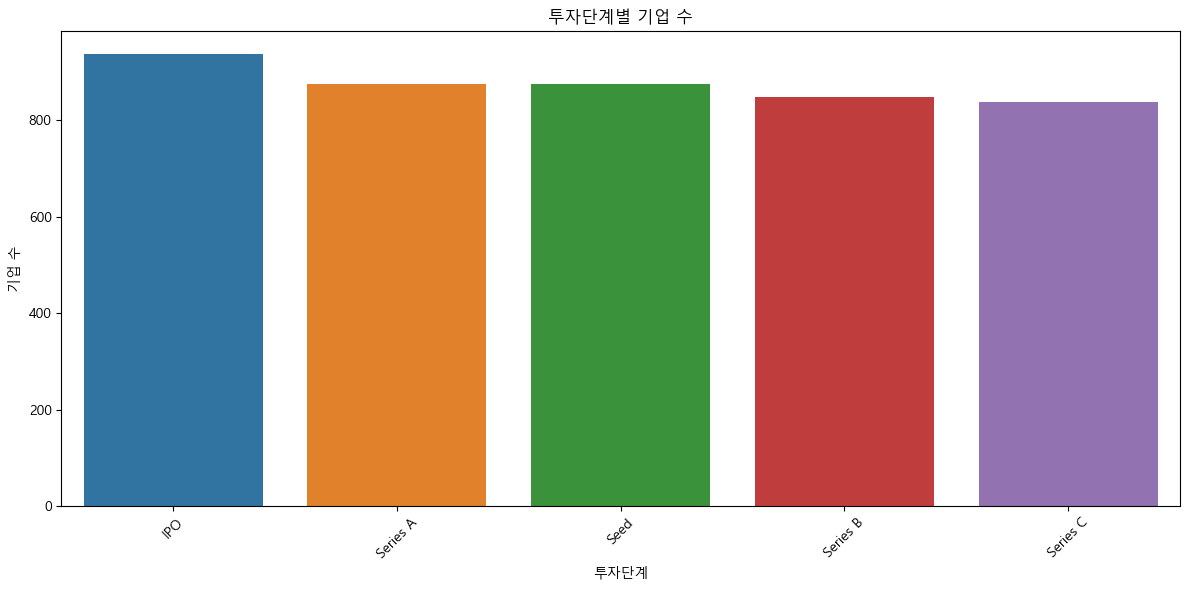

In [127]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train, x='투자단계', order=train['투자단계'].value_counts().index)

plt.title('투자단계별 기업 수')
plt.xlabel('투자단계')
plt.ylabel('기업 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Seed: 아이디어와 초기 제품을 위한 자금.

- Series A: 제품과 시장 검증 후, 성장 확대를 위한 자금.

- Series B: 성장을 지속적으로 확장하고, 더 큰 시장을 목표로 하는 자금.

- IPO: 주식 공개를 통해 자금을 조달하고, 기업을 공개적으로 운영하는 단계.

### 기업가치 처리

- 기업 가치 오브젝트 -> 수치형으로 변환

In [128]:
import pandas as pd

def convert_range_to_mean(value):
    if pd.isna(value):
        return None
    if '-' in value:
        # '2500-3500' → 평균 계산
        start, end = value.split('-')
        return (int(start) + int(end)) / 2
    else:
        # 숫자형 문자열이거나 'Missing' 처리된 값
        try:
            return float(value)
        except:
            return None

# 적용
train['기업가치(백억원)_수치형'] = train['기업가치(백억원)'].apply(convert_range_to_mean)

In [129]:
print(train['기업가치(백억원)_수치형'].dtype)  # float64로 변환되어야 함

float64


In [130]:
train.head()

,설립연도,국가,분야,투자단계,직원 수,인수여부,상장여부,고객수(백만명),총 투자금(억원),연매출(억원),SNS 팔로워 수(백만명),기업가치(백억원),성공확률,기업가치(백억원)_수치형
0,2009,CT005,이커머스,Series A,4126.0,0,0,56.0,3365.0,4764.0,4.71,NaN,0.3,NaN
1,2023,CT006,핀테크,Seed,4167.0,1,0,80.0,4069.0,279.0,1.00,2500-3500,0.8,3000.0
2,2018,CT007,기술,Series A,3132.0,1,1,54.0,6453.0,12141.0,4.00,3500-4500,0.5,4000.0
3,2016,CT006,NaN,Seed,3245.0,1,1,NaN,665.0,10547.0,2.97,NaN,0.7,NaN
4,2020,CT002,에듀테크,Seed,1969.0,0,1,94.0,829.0,9810.0,1.00,1500-2500,0.1,2000.0


In [131]:
# 상관계수 계산 (피어슨 상관계수)
correlation = train[['기업가치(백억원)_수치형', '성공확률']].corr(method='pearson')
print(correlation)

               기업가치(백억원)_수치형      성공확률
기업가치(백억원)_수치형       1.000000  0.009127
성공확률                0.009127  1.000000


In [132]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4376 entries, 0 to 4375
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   설립연도            4376 non-null   object 
 1   국가              4376 non-null   object 
 2   분야              3519 non-null   object 
 3   투자단계            4376 non-null   object 
 4   직원 수            4202 non-null   float64
 5   인수여부            4376 non-null   int64  
 6   상장여부            4376 non-null   int64  
 7   고객수(백만명)        3056 non-null   float64
 8   총 투자금(억원)       4376 non-null   float64
 9   연매출(억원)         4376 non-null   float64
 10  SNS 팔로워 수(백만명)  4376 non-null   float64
 11  기업가치(백억원)       3156 non-null   object 
 12  성공확률            4376 non-null   float64
 13  기업가치(백억원)_수치형   2563 non-null   float64
dtypes: float64(7), int64(2), object(5)
memory usage: 478.8+ KB


# 타입 변환 (int -> object)
train['인수여부'] =train['인수여부'].astype('object')
test['상장여부'] =test['상장여부'].astype('object')

In [133]:
correlation = train[['직원 수', '성공확률']].corr(method='pearson')
print(correlation)

          직원 수      성공확률
직원 수  1.000000 -0.011831
성공확률 -0.011831  1.000000


In [134]:
correlation = train[['고객수(백만명)', '성공확률']].corr(method='pearson')
print(correlation)

          고객수(백만명)      성공확률
고객수(백만명)  1.000000 -0.014746
성공확률     -0.014746  1.000000


In [135]:
correlation = train[['총 투자금(억원)', '성공확률']].corr(method='pearson')
print(correlation)

           총 투자금(억원)      성공확률
총 투자금(억원)   1.000000 -0.014939
성공확률       -0.014939  1.000000


In [136]:
correlation = train[['연매출(억원)', '성공확률']].corr(method='pearson')
print(correlation)

          연매출(억원)      성공확률
연매출(억원)  1.000000 -0.018994
성공확률    -0.018994  1.000000


In [137]:
correlation = train[['SNS 팔로워 수(백만명)', '성공확률']].corr(method='pearson')
print(correlation)

                SNS 팔로워 수(백만명)      성공확률
SNS 팔로워 수(백만명)        1.000000  0.017927
성공확률                  0.017927  1.000000


- 모두 상관계수가 1에 가깝지 않음 (강한 양의 상관관계를 보이지는 않음)
- 비선형회귀 혹은 다중회귀가 필요해보임

In [138]:
import statsmodels.api as sm

# 데이터 준비
X = train['기업가치(백억원)_수치형']
y = train['성공확률']

# 결측치 제거
data = pd.concat([X, y], axis=1).dropna()
X = data['기업가치(백억원)_수치형']
y = data['성공확률']

# 상수항 추가 (절편)
X = sm.add_constant(X)

# 회귀 모델 적합
model = sm.OLS(y, X).fit()

# 결과 출력
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   성공확률   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2134
Date:                Wed, 14 May 2025   Prob (F-statistic):              0.644
Time:                        13:39:44   Log-Likelihood:                 10.864
No. Observations:                2563   AIC:                            -17.73
Df Residuals:                    2561   BIC:                            -6.031
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5243      0.015     35.159

In [139]:
#성공확률이 80% 이상
train[train['성공확률'] > 0.8]

,설립연도,국가,분야,투자단계,직원 수,인수여부,상장여부,고객수(백만명),총 투자금(억원),연매출(억원),SNS 팔로워 수(백만명),기업가치(백억원),성공확률,기업가치(백억원)_수치형
8,2005,CT002,NaN,Series B,NaN,0,0,NaN,2722.0,2568.0,4.94,NaN,0.9,NaN
12,2020,CT005,기술,Seed,528.0,1,0,92.0,239.0,2954.0,3.14,NaN,0.9,NaN
14,2009,CT002,헬스케어,Seed,937.0,1,1,19.0,5522.0,6509.0,4.00,3500-4500,0.9,4000.0
22,2004,CT007,NaN,Series A,4957.0,1,1,NaN,96.0,7304.0,4.08,NaN,0.9,NaN
26,2018,CT003,게임,IPO,389.0,0,1,87.0,77.0,129.0,4.00,2500-3500,0.9,3000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319,2021,CT010,NaN,Seed,4473.0,0,1,NaN,1577.0,4167.0,2.78,NaN,0.9,NaN
4334,2020,CT009,게임,Seed,4449.0,0,1,64.0,196.0,5098.0,4.00,1500-2500,0.9,2000.0
4342,2006,CT007,헬스케어,Series A,3695.0,1,1,45.0,1912.0,1362.0,2.95,NaN,0.9,NaN
4370,2005,CT006,NaN,Series A,237.0,0,0,NaN,6252.0,759.0,4.31,NaN,0.9,NaN


In [140]:
train[train['성공확률'] < 0.2]

,설립연도,국가,분야,투자단계,직원 수,인수여부,상장여부,고객수(백만명),총 투자금(억원),연매출(억원),SNS 팔로워 수(백만명),기업가치(백억원),성공확률,기업가치(백억원)_수치형
4,2020,CT002,에듀테크,Seed,1969.0,0,1,94.0,829.0,9810.0,1.00,1500-2500,0.1,2000.0
11,2002,CT001,에듀테크,Series C,1026.0,0,1,74.0,2301.0,9308.0,2.00,2500-3500,0.1,3000.0
16,2009,CT003,물류,Seed,2083.0,1,1,61.0,2294.0,5652.0,1.00,4500-6000,0.1,5250.0
25,2009,CT004,NaN,Seed,1098.0,1,0,NaN,2152.0,10885.0,0.80,NaN,0.1,NaN
38,2011,CT001,기술,Series A,2127.0,1,0,85.0,3975.0,7481.0,1.00,3500-4500,0.1,4000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4350,2004,CT004,헬스케어,Series B,512.0,1,0,91.0,774.0,6278.0,4.00,4500-6000,0.1,5250.0
4352,2010,CT009,기술,Series C,3284.0,0,1,18.0,5885.0,2880.0,1.00,4500-6000,0.1,5250.0
4360,2003,CT003,NaN,Series C,NaN,0,0,NaN,4786.0,4053.0,1.15,NaN,0.1,NaN
4361,2014,CT001,NaN,Series A,4971.0,1,0,NaN,2820.0,10761.0,3.84,2500-3500,0.1,3000.0


| 알고리즘                                                                  | 개념 요약                | 장점                                           | 단점                                   | 추천 상황               |
| --------------------------------------------------------------------- | -------------------- | -------------------------------------------- | ------------------------------------ | ------------------- |
| **1. 선형 회귀 (Linear Regression)**                                      | 독립변수의 선형 조합으로 타깃 예측  | - 빠르고 해석 쉬움<br>- 과적합 적음                      | - 비선형 관계에 약함<br>- 이상치에 민감            | - 단순하고 선형 관계 예상될 때  |
| **2. 랜덤 포레스트 회귀 (RandomForestRegressor)**                             | 여러 결정 트리를 앙상블해 평균 예측 | - 비선형도 잘 처리<br>- 이상치와 결측치에 강함<br>- 변수 중요도 제공 | - 느릴 수 있음<br>- 해석 어려움                | - 데이터가 복잡하고 비선형일 때  |
| **3. 그레이디언트 부스팅 회귀 (GradientBoostingRegressor / XGBoost / LightGBM)** | 약한 모델을 반복적으로 개선하는 방식 | - 고성능<br>- 정교한 예측 가능<br>- 하이퍼파라미터 다양         | - 과적합 위험<br>- 파라미터 조정 필요             | - 정확도가 중요한 경우, 대회 등 |
| **4. KNN 회귀 (KNeighborsRegressor)**                                   | 주변의 K개 이웃의 평균으로 예측   | - 모델 구조 간단<br>- 훈련 시간 거의 없음                  | - 예측 느림<br>- 고차원에서 성능 저하<br>- 이상치 민감 | - 데이터 수 적고 단순할 때    |
| **5. 신경망 회귀 (MLPRegressor / 딥러닝)**                                    | 여러 은닉층을 통해 복잡한 함수 근사 | - 고차원, 복잡한 패턴 잘 잡음<br>- 비선형 모델링 우수           | - 학습시간 길고<br>- 과적합 위험<br>- 해석 어려움    | - 데이터 많고 복잡한 문제에 적합 |


그레이디언트 부스팅 회귀 (GradientBoostingRegressor / XGBoost / LightGBM)

In [141]:
train.isna().sum()# 기업가치(백억원)_수치형 컬럼 따로 저장
기업가치_수치형 = train['기업가치(백억원)_수치형'].copy()

# train에서 해당 컬럼 제거
train = train.drop(columns=['기업가치(백억원)_수치형'])

In [142]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4376 entries, 0 to 4375
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   설립연도            4376 non-null   object 
 1   국가              4376 non-null   object 
 2   분야              3519 non-null   object 
 3   투자단계            4376 non-null   object 
 4   직원 수            4202 non-null   float64
 5   인수여부            4376 non-null   int64  
 6   상장여부            4376 non-null   int64  
 7   고객수(백만명)        3056 non-null   float64
 8   총 투자금(억원)       4376 non-null   float64
 9   연매출(억원)         4376 non-null   float64
 10  SNS 팔로워 수(백만명)  4376 non-null   float64
 11  기업가치(백억원)       3156 non-null   object 
 12  성공확률            4376 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 444.6+ KB


In [143]:
# LabelEncoder 객체를 각 범주형 feature별로 따로 저장하여 사용
encoders = {}

# 범주형 데이터를 encoding
for feature in category_features:
    encoders[feature] = LabelEncoder()
    train[feature] = train[feature].fillna('Missing')
    test[feature] = test[feature].fillna('Missing')
    train[feature] = encoders[feature].fit_transform(train[feature])
    test[feature] = encoders[feature].transform(test[feature])

# 수치형 변수 결측치를 평균값으로 대체
for feature in numeric_features:
    mean_value = train[feature].mean()
    train[feature] = train[feature].fillna(mean_value)
    test[feature] = test[feature].fillna(mean_value)

# TabNet용 범주형 변수 인덱스(cat_idxs) 및 차원(cat_dims) 설정
features = [col for col in train.columns if col != '성공확률']
cat_idxs = [features.index(col) for col in category_features]
cat_dims = [train[col].max() + 1 for col in category_features]

In [144]:
train = train

# K-Fold Model Training

- K-Fold와 GradientBoostingRegressor 성능 비교

In [145]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
import numpy as np

# 가정: features, cat_idxs, cat_dims, train = 전처리 완료 상태

X = train[features]
y = train['성공확률']

N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

tabnet_models, gbr_models = [], []
tabnet_scores, gbr_scores = [], []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    print(f"\n🔁 Fold {fold+1}/{N_FOLDS}")

    X_train = X.iloc[train_idx].values
    y_train = y.iloc[train_idx].values.reshape(-1, 1)
    X_valid = X.iloc[valid_idx].values
    y_valid = y.iloc[valid_idx].values.reshape(-1, 1)

    # ⚙️ Pretraining TabNet
    pretrainer = TabNetPretrainer(
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        seed=42,
        verbose=0
    )
    pretrainer.fit(
        X_train=X_train,
        max_epochs=100,
        batch_size=512,
        virtual_batch_size=64
    )

    # ✅ TabNet Fine-tuning
    tabnet_model = TabNetRegressor(
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        seed=42,
        verbose=0,
        optimizer_fn=torch.optim.AdamW
    )
    tabnet_model.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_valid, y_valid)],
        from_unsupervised=pretrainer,
        eval_metric=['mae'],
        max_epochs=100,
        patience=10
    )
    tabnet_models.append(tabnet_model)
    tabnet_scores.append(tabnet_model.best_cost)
    print(f"📉 TabNet MAE: {tabnet_model.best_cost:.4f}")

    # ✅ Gradient Boosting Regressor
    gbr_model = GradientBoostingRegressor(random_state=42)
    gbr_model.fit(X_train, y_train.ravel())
    gbr_pred = gbr_model.predict(X_valid)
    gbr_mae = mean_absolute_error(y_valid, gbr_pred)
    gbr_models.append(gbr_model)
    gbr_scores.append(gbr_mae)
    print(f"🌲 GBR MAE: {gbr_mae:.4f}")

# 평균 성능 출력
print("\n✅ 모든 fold 학습 완료!")
print(f"\n📊 TabNet 평균 MAE: {np.mean(tabnet_scores):.4f}")
print(f"📊 GBR 평균 MAE: {np.mean(gbr_scores):.4f}")



🔁 Fold 1/5


C:\Users\starf\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
C:\Users\starf\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_0_mae = 0.2035


C:\Users\starf\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


📉 TabNet MAE: 0.2035
🌲 GBR MAE: 0.2067

🔁 Fold 2/5


C:\Users\starf\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
C:\Users\starf\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_mae = 0.20604


C:\Users\starf\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


📉 TabNet MAE: 0.2060
🌲 GBR MAE: 0.2070

🔁 Fold 3/5


C:\Users\starf\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
C:\Users\starf\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_mae = 0.20658
📉 TabNet MAE: 0.2066


C:\Users\starf\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


🌲 GBR MAE: 0.2024

🔁 Fold 4/5


C:\Users\starf\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
C:\Users\starf\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_0_mae = 0.20125


C:\Users\starf\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


📉 TabNet MAE: 0.2013
🌲 GBR MAE: 0.2023

🔁 Fold 5/5


C:\Users\starf\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
C:\Users\starf\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 56 with best_epoch = 46 and best_val_0_mae = 0.20536


C:\Users\starf\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


📉 TabNet MAE: 0.2054
🌲 GBR MAE: 0.2068

✅ 모든 fold 학습 완료!

📊 TabNet 평균 MAE: 0.2045
📊 GBR 평균 MAE: 0.2050


# 타겟 지정
target = train['성공확률']  
X = train[features]
y = target

# KFold 설정
N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

models = [] # 모델 저장 리스트
cv_scores = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    print(f"\n🔁 Fold {fold+1}/{N_FOLDS}")
    
    X_train = X.iloc[train_idx].values
    y_train = y.iloc[train_idx].values.reshape(-1, 1)
    
    X_valid = X.iloc[valid_idx].values
    y_valid = y.iloc[valid_idx].values.reshape(-1, 1)
    
    # 비지도 사전학습
    print("▶ Pretraining...")

    pretrainer = TabNetPretrainer(
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        seed=42,
        verbose=0
    )

    pretrainer.fit(
        X_train=X_train,
        max_epochs=100,
        batch_size=512,
        virtual_batch_size=64
    )

    # 지도 학습 
    print("▶ Fine-tuning...")
    model = TabNetRegressor(
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        seed=42,
        verbose=0,
        optimizer_fn=torch.optim.AdamW 
    )

    model.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_valid, y_valid)],
        from_unsupervised=pretrainer,
        eval_metric=['mae'],
        max_epochs=100,
        patience=10
    )

    # 모델을 메모리에 저장
    models.append(model)
    cv_scores.append(model.best_cost)

print("\n✅ 모든 fold 모델 학습 완료!")

# K-Fold Model Prediction

# 저장된 모델들로 예측
predictions_list = []

for fold, model in enumerate(models):
    print(f"Predict with fold {fold+1}")
    preds = model.predict(test[features].values)
    predictions_list.append(preds)

# 평균 예측
final_predictions = np.mean(predictions_list, axis=0)

# Submission

sample_submission['성공확률'] = final_predictions
sample_submission.to_csv('./baseline_submission.csv', index = False, encoding = 'utf-8-sig')